https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [ ]:
import os
import zipfile

In [ ]:
!wget -c https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
print('done!')

--2020-12-12 13:46:45--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.97.95, 13.225.97.116, 13.225.97.19, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.97.95|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
done!


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [ ]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Irish.txt', 'data/names/Spanish.txt', 'data/names/Scottish.txt', 'data/names/Vietnamese.txt', 'data/names/Japanese.txt', 'data/names/French.txt', 'data/names/Korean.txt', 'data/names/English.txt', 'data/names/Chinese.txt', 'data/names/Dutch.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Italian.txt', 'data/names/Greek.txt', 'data/names/Russian.txt', 'data/names/Czech.txt', 'data/names/Portuguese.txt', 'data/names/Polish.txt']


In [ ]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [ ]:
#len(string.ascii_letters)

52

In [ ]:
filename = 'data/names/English.txt'
os.path.splitext(os.path.basename(filename))[0]

'English'

In [ ]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [ ]:
#len(all_categories)
print((category_lines['Italian'][0:5]))

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turning into tensor

In [ ]:
import torch

In [ ]:
# find letter index form all_letters
def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)]=1
  return tensor 


In [ ]:
def lineToTensor(line):
  tensor = torch.zeros(len(line),1,n_letters)
  for li,l in enumerate(line):
    tensor[li][0][letterToIndex(l)] = 1
  return tensor

In [ ]:
#print(letterToTensor('J'))
print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


# Creating The RNN network

In [ ]:
import torch.nn as nn


In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    #self.input_size = input_size

    self.i2h = nn.Linear(input_size+ hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size+ hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim = 1)
  
  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden 

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)


In [ ]:
n_letters

57

In [ ]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
inp = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(inp, hidden)
print(output)
print(next_hidden.shape)

tensor([[-2.8529, -2.9172, -2.9163, -2.8434, -2.9421, -2.9584, -2.8782, -2.8244,
         -2.8544, -2.9015, -2.8532, -2.9456, -2.8388, -2.9458, -2.9224, -2.8596,
         -2.9018, -2.8859]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 128])


In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8529, -2.9172, -2.9163, -2.8434, -2.9421, -2.9584, -2.8782, -2.8244,
         -2.8544, -2.9015, -2.8532, -2.9456, -2.8388, -2.9458, -2.9224, -2.8596,
         -2.9018, -2.8859]], grad_fn=<LogSoftmaxBackward>)


In [ ]:
# get the index of the greatest value : 
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 7)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Kirkpatrick
category = French / line = Sarkozi
category = Chinese / line = Shen
category = Italian / line = Boveri
category = Czech / line = Matocha
category = Portuguese / line = Silveira
category = Scottish / line = Anderson
category = Russian / line = Shakhurin
category = Arabic / line = Seif
category = Polish / line = Jaskulski


# Training the network()

In [ ]:
# Loss function :
criterion = nn.NLLLoss()

In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math


In [ ]:
n_iters = 100000
print_every = 5000
plot_every = 1000


In [ ]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.6403 Weeks / Greek ✗ (English)
10000 10% (0m 13s) 1.4984 Nahas / Arabic ✓
15000 15% (0m 20s) 2.2728 Chilar / Arabic ✗ (Czech)
20000 20% (0m 27s) 1.7651 Simpson / Russian ✗ (Scottish)
25000 25% (0m 34s) 2.8061 Mcloughlin / Irish ✗ (English)
30000 30% (0m 41s) 0.9787 Xiong / Chinese ✓
35000 35% (0m 47s) 1.2932 Yim / Korean ✗ (Chinese)
40000 40% (0m 54s) 2.9706 William / Czech ✗ (Irish)
45000 45% (1m 1s) 4.7662 Wykruta / Japanese ✗ (Czech)
50000 50% (1m 8s) 0.7371 Hlobystin / Russian ✓
55000 55% (1m 15s) 0.7136 Samaha / Arabic ✓
60000 60% (1m 23s) 0.8998 Miller / Scottish ✓
65000 65% (1m 30s) 0.1406 Shinozaki / Japanese ✓
70000 70% (1m 36s) 1.8194 Riedel / Dutch ✗ (Czech)
75000 75% (1m 43s) 2.0691 Hanania / Czech ✗ (Arabic)
80000 80% (1m 50s) 0.9113 Krhovsky / Russian ✗ (Czech)
85000 85% (1m 56s) 0.7060 Piatek / Polish ✓
90000 90% (2m 3s) 0.1841 Maloof / Arabic ✓
95000 95% (2m 10s) 1.5562 Thurston / Russian ✗ (English)
100000 100% (2m 17s) 1.4641 Anselmetti / Italian ✓


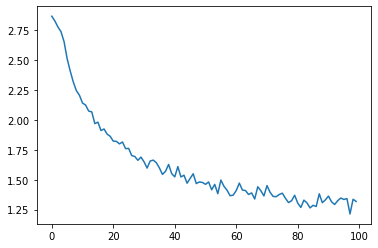

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

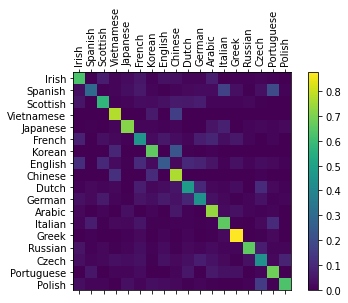

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.83) Czech
(-0.96) Russian
(-2.52) English

> Jackson
(-0.44) Scottish
(-1.70) English
(-2.78) Russian

> Satoshi
(-1.14) Japanese
(-1.67) Arabic
(-1.79) Polish


# Generating names with a character level RNN 

https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [ ]:
import os 
import zipfile 


In [ ]:
!wget -c https://download.pytorch.org/tutorial/data.zip
!unzip data.zip 
print('done')

--2020-12-22 12:19:08--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.97.19, 13.225.97.116, 13.225.97.95, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.97.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  13.9MB/s    in 0.2s    

2020-12-22 12:19:09 (13.9 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Itali

In [ ]:
from __future__ import unicode_literals, print_function, division 
from io import open 
import os 
import glob
import unicodedata
import string 

In [ ]:
all_letters = string.ascii_letters+ " .,;'-"
n_letters  = len(all_letters)+1

In [ ]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-"

In [ ]:
def findFiles(path): return glob.glob(path)

In [ ]:
# convert from unicode to ASCii
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c)!= 'Mn'
      and c in all_letters
      
  )

In [ ]:
# read file and split into line and return result as list :

def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

In [ ]:
# build category_lines dictionary , and list of all categories 
category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)
print('categories:', n_categories, all_categories)

categories: 18 ['Italian', 'Korean', 'Irish', 'French', 'Greek', 'Polish', 'Arabic', 'Portuguese', 'German', 'Russian', 'Japanese', 'Czech', 'English', 'Dutch', 'Chinese', 'Vietnamese', 'Scottish', 'Spanish']


In [ ]:
(category_lines['Italian'][1:5])

['Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

In [ ]:
n_categories


18

# Network

In [ ]:
import torch 
import torch.nn as nn


In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear(n_categories+ input_size+ hidden_size, hidden_size )
    self.i2o = nn.Linear(n_categories+ input_size + hidden_size, output_size)
    self.o2o = nn.Linear(hidden_size+output_size, output_size)

    self.dropout = nn.Dropout(0.1)
    self.solfmax = nn.LogSoftmax(dim = 1)

  def forward(self, category, input, hidden):
    input_combined = torch.cat((category, input, hidden), 1)
    i2o = self.i2o(input_combined)
    i2h = self.i2h(input_combined)

    output_combined = torch.cat((i2o, i2h), dim = 1)
    o2o = self.o2o(output_combined)

    o2o = self.dropout(o2o)
    return self.solfmax(o2o), i2h
  
  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [ ]:
# help the training  

In [ ]:
import random 

# random item from a list 
def randomChoice(l):
  return l[ random.randint(0, len(l)-1) ]


def randomTrainingPair():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  return category, line
  

In [ ]:
randomTrainingPair()

('Japanese', 'Nakasone')

In [ ]:
def categoryTensor(category):
  li = all_categories.index(category)
  tens = torch.zeros(1, n_categories)
  tens[0][li] = 1
  return tens

In [ ]:
categoryTensor( 'Korean')

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
def inputTensor(line):
  tens = torch.zeros(len(line), 1,n_letters )
  for li, l in enumerate(line):
    tens[li][0][all_letters.find(l)]=1
  return tens 

In [ ]:
inputTensor('Ali')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]])

In [ ]:
def targetTensor(line):
  letter_indexes = [all_letters.find(line[li]) for li in range(1,len(line))]
  letter_indexes.append(n_letters -1 ) #EOS
  return torch.LongTensor(letter_indexes)

In [ ]:
def randomTrainingExample():
  category , line = randomTrainingPair()
  category_tensor = categoryTensor(category)
  input_line_tensor = inputTensor(line)
  target_line_tensor = targetTensor(line)
  return category_tensor, input_line_tensor, target_line_tensor

In [ ]:
# training the network : 

criterion = nn.NLLLoss()
learning_rate = 0.0005

In [ ]:
def train(category_tensor, input_line_tensor, target_line_tensor):
  target_line_tensor.unsqueeze_(-1)
  hidden = rnn.initHidden()

  rnn.zero_grad()
  loss = 0
  for i in range(input_line_tensor.size(0)):
    output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
    l = criterion(output, target_line_tensor[i])
    loss +=l  # the loss is the sum of losses obtained after every predection ol letter

  loss.backward() # 

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha =- learning_rate)
  return output, loss.item()/input_line_tensor.size(0)

In [ ]:
import time 
import math 


In [ ]:
def timeSince(since):
  now = time.time()
  s = now -since
  m = math.floor(s/60)
  s -=m*60
  return '%dm %ds' % (m,s)


In [ ]:
#randomTrainingExample()

In [ ]:
rnn = RNN(n_letters, 128, n_letters)
n_iters = 100000
print_every = 5000
plot_every = 500
all_loss = [] # visualisation 
total_loss = 0 # reset every plot iter

start = time.time() # begin of the trainning process 

for iter in range(1, n_iters+1):
  output, loss = train(*randomTrainingExample())
  total_loss += loss 
  if iter% print_every ==0:
    print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
  
  if iter% plot_every ==0:
    all_loss.append(total_loss/plot_every)
    total_loss = 0 # reset 



0m 19s (5000 5%) 2.7378
0m 38s (10000 10%) 2.5159
0m 57s (15000 15%) 2.4979
1m 17s (20000 20%) 2.1268
1m 36s (25000 25%) 2.8711
1m 55s (30000 30%) 2.2647
2m 13s (35000 35%) 1.9541
2m 33s (40000 40%) 1.4979
2m 52s (45000 45%) 2.7440
3m 11s (50000 50%) 2.6517
3m 30s (55000 55%) 2.2033
3m 49s (60000 60%) 2.1683
4m 7s (65000 65%) 1.9683
4m 26s (70000 70%) 2.5193
4m 45s (75000 75%) 2.5731
5m 5s (80000 80%) 2.0960
5m 24s (85000 85%) 2.5743
5m 42s (90000 90%) 1.7792
6m 1s (95000 95%) 2.2773
6m 20s (100000 100%) 2.2823


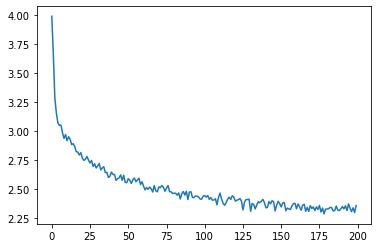

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_loss)
plt.show()

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1) # gives top k and their index 
            topi = topi[0][0] 
            if topi == n_letters - 1: # if it is EOS 
                break
            else:
                letter = all_letters[topi]
                output_name += letter # concatenation 
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [ ]:
samples('Russian', 'RUS')

Rovakov
Uakovaki
Shavakiv
